In [15]:
import gym
import numpy as np
import tensorflow as tf
import keras.layers as L
import keras
from collections import deque
from IPython.display import clear_output
import random
import matplotlib.pyplot as plt
%matplotlib inline


sess = tf.InteractiveSession()
keras.backend.set_session(sess)

plt.rcParams['figure.figsize'] = (14.0, 6.0)

In [16]:
class DQNAgent(object):
    
    def __init__(self, env, epsilon, gamma, state_dim, action_dim, replay, double = False):
        
        self.epsilon = epsilon
        self.gamma = gamma
        self.env = env
        self.memory = replay
        
        #agent network
        self.network = keras.models.Sequential()
        self.network.add(L.InputLayer(state_dim))
        self.network.add(L.Dense(units = 64, activation='relu'))
        self.network.add(L.Dense(units = 64, activation='relu'))
        self.network.add(L.Dense(units = action_dim, activation='linear'))
        
        self.target_network = keras.models.clone_model(self.network) 
        #self.target_network.trainable = False
                
        self.states_ph = tf.placeholder('float32', shape=(None,) + state_dim)
        self.actions_ph = tf.placeholder('int32', shape=[None])
        self.rewards_ph = tf.placeholder('float32', shape=[None])
        self.next_states_ph = tf.placeholder('float32', shape=(None,) + state_dim)
        self.is_done_ph = tf.placeholder('bool', shape=[None])
        
        #get q-values for all actions in current states
        self.qvalues = self.network(self.states_ph)
        self.choosen_qvalues = tf.reduce_sum(self.qvalues * tf.one_hot(self.actions_ph, action_dim), axis=1)
        
        # compute q-values for all actions in next states
        if double:
            self.next_qvalues = self.target_network(self.next_states_ph)
            self.next_qvalues_agent = self.network(self.next_states_ph)
            self.next_action = tf.argmax(self.next_qvalues_agent, axis = 1)
            self.choosen_next_qvalues = tf.reduce_sum(self.next_qvalues * tf.one_hot(self.next_action, action_dim), axis = 1)
        else:
            self.next_qvalues = self.target_network(self.next_states_ph)
            
            # compute V*(next_states) using predicted next q-values
            self.choosen_next_qvalues = tf.reduce_max(self.next_qvalues, axis=1)

        # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
        self.target_qvalue = (self.rewards_ph + (self.gamma * self.choosen_next_qvalues))
        self.target_qvalue = tf.where(self.is_done_ph, self.rewards_ph, self.target_qvalue)

        #mean squared error loss to minimize
        self.loss = tf.reduce_mean((self.choosen_qvalues - (self.target_qvalue)) ** 2)

        # training function that resembles agent.update(state, action, reward, next_state) from tabular agent
        self.train_step = tf.train.AdamOptimizer(1e-4).minimize(self.loss, var_list=self.network.weights)
        
       
    def get_action(self, state):

        q_values = self.network.predict(state[None])[0]

        if np.random.random() <= self.epsilon:
            a = self.env.action_space.sample()
        else:
            a = np.argmax(q_values)

        return a

    def train_network(self, train = False, t_max = 1000, episodes = 1000, eps_decrease = 100
                    ,w_update = 300, render = False):
        
        rewards = []
        
        for i in range(episodes):
            
            total_rewards = 0
            s = self.env.reset()

            if i % eps_decrease == 0:
                self.epsilon *= 0.9
                clear_output(True)
                plt.plot(rewards)
                plt.show()
                print(self.epsilon)
                
            if i % w_update == 0:
                try:
                    self.target_network.set_weights(self.network.get_weights())
                except:
                    pass
                                               
            for t in range(t_max):
                
                if render:
                    clear_output(True)
                    plt.imshow(self.env.render('rgb_array'))
                    plt.show()
                
                a = self.get_action(s)
                next_s, r, done, _ = self.env.step(a)
                total_rewards += r
                
                self.memory.add(s, a, r, next_s, done)

                if train:
                    sess.run(self.train_step,{
                            self.states_ph: [s], self.actions_ph: [a], self.rewards_ph: [r], 
                            self.next_states_ph: [next_s], self.is_done_ph: [done]
                    })

                if done:
                    break
                else:
                    s = next_s
            
            #replay Training
            if len(self.memory.memory) <= self.memory.batch_size:
                batch = len(self.memory.memory)
            else:
                batch = self.memory.batch_size
            mini_batch = random.sample(self.memory.memory, batch)
            for s, a, r, next_s, done in mini_batch:
                if train:
                    sess.run(self.train_step,{
                            self.states_ph: [s], self.actions_ph: [a], self.rewards_ph: [r], 
                            self.next_states_ph: [next_s], self.is_done_ph: [done]
                    })

            rewards.append(total_rewards)
            total_rewards = 0
                
        return None
    
class replay(object):
    
    def __init__(self, memory_len = 100000, batch_size = 64):
        self.memory = deque(maxlen=memory_len)
        self.batch_size = batch_size
        
    def add(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

In [17]:
env = gym.make('CartPole-v0')
action = env.action_space.n
states = env.observation_space.shape
rep = replay()
agent = DQNAgent(env, epsilon = 0.5, gamma = 0.99, state_dim = states, action_dim = action, replay = rep, double = False)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


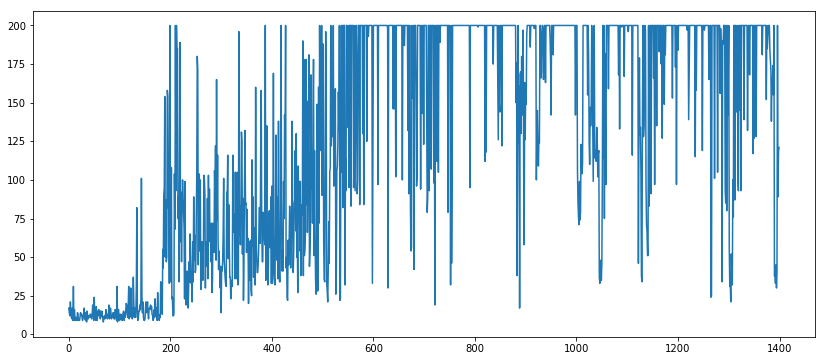

0.10294556604732455


In [18]:
agent.train_network(train = True, episodes = 1500, w_update = 10)

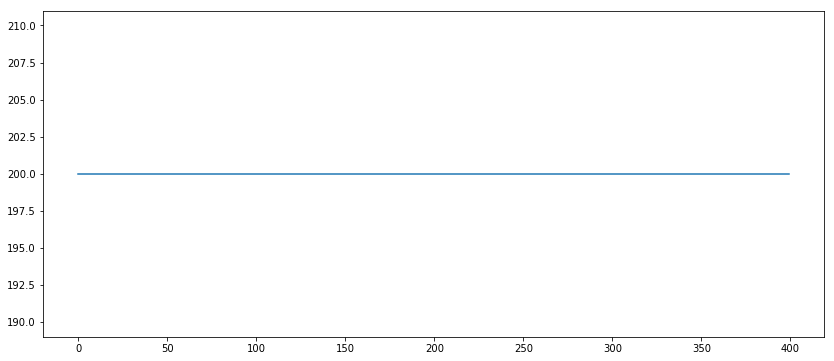

0.0


In [19]:
agent.epsilon = 0
agent.train_network(train = False, episodes = 500, w_update = 9999999)

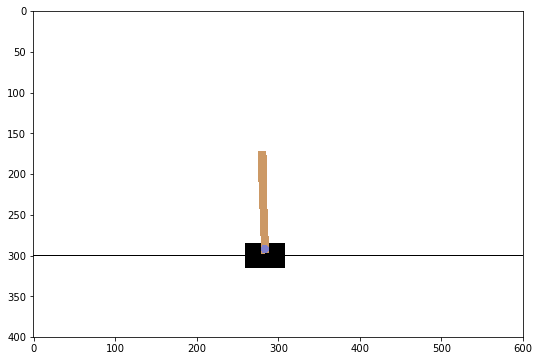

In [20]:
agent.epsilon = 0
agent.train_network(train = False, episodes = 1, w_update = 9999999, render = True)